### Evaluation of Manipulation experiments

In [1]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt

%matplotlib notebook
from IPython.display import display

In [2]:
import os
import numpy as np
import signal_logger
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['axes.grid'] = True
import rospkg

from utilities import *

rospack = rospkg.RosPack()
DO_COMPARATIVE_ANALYSIS = True
ROOT_DIR = os.path.join(rospack.get_path("mppi_manipulation_royalpanda"),
                        "logs", "comparison_13_09_21")
LOG_PREFIX = "shelf"
LOG_FILE = os.path.join(ROOT_DIR, "filter.silo")
LOG_FILES = get_files(ROOT_DIR, LOG_PREFIX)
REQUIRED_FIELDS = [
    "log/sim_time", "log/stage_cost", "log/torque_command",
    "log/cartesian_limits_violation", "log/joint_limits_violation",
    "log/solver/rollouts/min_cost", "log/velocity_command",
    "log/velocity_filtered", "log/velocity_measured", "log/position_desired", "log/position_measured",
    "log/tank_state", "log/solver/delay_steps", "log/power_from_error", 
    "log/power_from_interaction", "log/total_power_exchange", "log/external_torque", "log/power_channels",
    "log/ground_truth_external_torque", "log/external_wrench", "log/external_wrench_filtered", 
    #"log/state", "log/nominal_state"
]
LOG_FILES_PRINT = '\n'.join(LOG_FILES)
print(f"""
>> Root dir: 
{ROOT_DIR}
>> Prefix: 
{LOG_PREFIX}
>> Log files: 
{LOG_FILES_PRINT}
""")


>> Root dir: 
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_21
>> Prefix: 
shelf
>> Log files: 
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_21/shelf_1_filter_in_out.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_21/shelf_0_filter_in_out.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_21/shelf_1_filter_in.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_21/shelf_1.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_21/shelf_1_filter_out.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/comparison_13_09_2

### Fields available in log fie

In [3]:
silo = signal_logger.Silo(LOG_FILES[0])
#print_keys(silo)

Removing prefix /log/ which is common to all signals


### Some utilities
Use the naming convention to determine if the experiment was run with or without the filter and which object we try to manipulate

In [4]:
class ExperimentType:
    NO_FILTER = "no_filter"
    FILTER_OUT = "filter_out"
    FILTER_IN = "filter_in"
    FILTER_IN_OUT = "filter_in_out"
    
    @classmethod
    def get_labels(cls):
        return ["NO_FILTER", "FILTER_OUT", "FILTER_IN", "FILTER_IN_OUT"]
    
def experiment_type_from_name(name):
    if "filter_in_out" in name:
        return ExperimentType.FILTER_IN_OUT
    elif "filter_in" in name:
        return ExperimentType.FILTER_IN 
    elif "filter_out" in name:
        return ExperimentType.FILTER_OUT
    else:
        return ExperimentType.NO_FILTER

    
def get_object_from_name(name):
    object_types = ['shelf', 'door', 'microwave', 'drawer', 'valve']
    for object_type in object_types:
        if object_type in name:
            return object_type
    return 'none'

### Collect and process
Each experiment contributes to a single dictionary where all the information is stored

In [5]:
final_time = 35.0
data = {}
data['experiment_name'] = []
data['joint_limits_violation_se'] = []
data['cartesian_limits_violation_se'] = []
data['average_wrench_norm'] = []
data['experiment_type'] = []
data['object_type'] = []
data['x'] = []

for experiment_idx, file in enumerate(LOG_FILES):
    experiment_name = file.split('/')[-1].replace('.silo', '')
    silo = signal_logger.Silo(file)
    silo_dict = to_dictionary(silo, REQUIRED_FIELDS)

    for key, value in silo_dict.items():
        if experiment_idx == 0:
            data[key] = [value]
        else:
            data[key].append(value)
    
    time = silo_dict['sim_time']
    joint_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['joint_limits_violation'])
    carts_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['cartesian_limits_violation'])
    average_wrench = average_col_norm(time, 0.0, final_time, silo_dict['external_wrench_filtered'])
    
    data['experiment_name'].append(experiment_name)
    data['joint_limits_violation_se'].append(joint_violation_se)
    data['cartesian_limits_violation_se'].append(carts_violation_se)
    data['average_wrench_norm'].append(average_wrench)
    data['experiment_type'].append(experiment_type_from_name(experiment_name))
    data['object_type'].append(get_object_from_name(experiment_name))
    data['x'].append('data')

data = pd.DataFrame.from_dict(data)

Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals


### Select experiment to plot

In [6]:
exp_idx = 0
exp_name_wg = widgets.Dropdown(options=data['experiment_name'])
def exp_name_handler(exp_name):
    exp_idx = data['experiment_name'].index(exp_name)
exp_name_wg.observe(exp_name_handler, names='value')

### Delay steps
The solver keeps track of delay in optimizing the plan to adapt which portion of input is optimized in the future.
We then plot, what is the average deviation with respect to the nominal state. This should highlight the importance of the awareness of the required optimization time. 

Plotting shelf_1_filter_in_out


<IPython.core.display.Javascript object>


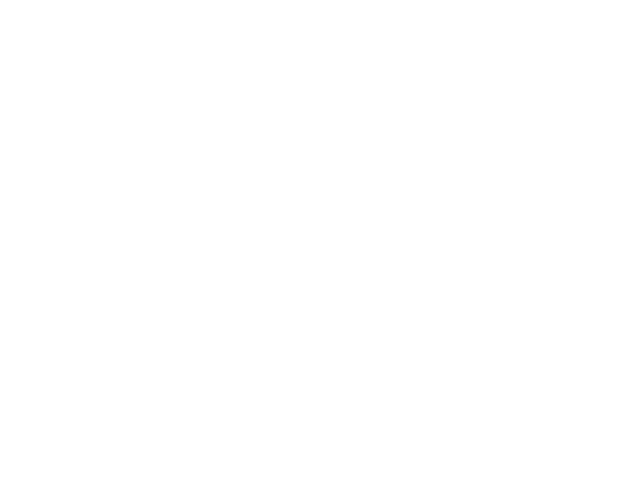

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'delay steps')

In [7]:
exp_idx = 0
print(f"Plotting {data['experiment_name'][exp_idx]}")
ax = scalar_plot(data['sim_time'][exp_idx], data['delay_steps'][exp_idx], prefix="delay_steps")
ax.set_title("delay steps")

# ax2 = scalar_plot(data['sim_time'][exp_idx], data['state'][exp_idx][:, 4], prefix="state")
# ax2 = scalar_plot(data['sim_time'][exp_idx], data['nominal_state'][exp_idx][:, 4], prefix="nominal_state",
#                  linestyle="--", axis=ax2)
# ax2.set_title("State vs Nominal State")
# average_deviation = matrix_to_se(time, 0.0, final_time, 
#                                  data['state'][exp_idx][:, :12] - 
#                                  data['nominal_state'][exp_idx][:, :12]) / (len(time) * 12)
# print(f"Average deviation = {average_deviation}")

### Wrench 

<IPython.core.display.Javascript object>


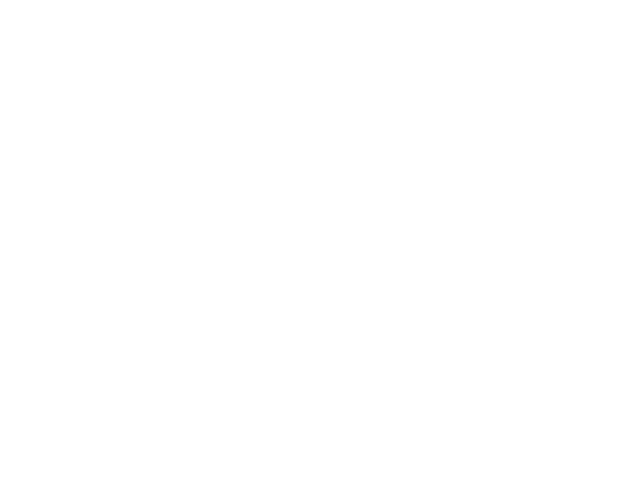

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'External wrench')

In [8]:
ax = matrix_plot(data['sim_time'][exp_idx], data['external_wrench_filtered'][exp_idx], prefix="filt")
#ax = matrix_plot(data['sim_time'][exp_idx], data['external_wrench'][exp_idx], prefix="raw",
#                axis=ax, linestyle="--")
ax.set_title("External wrench")

### Energy tank

<IPython.core.display.Javascript object>


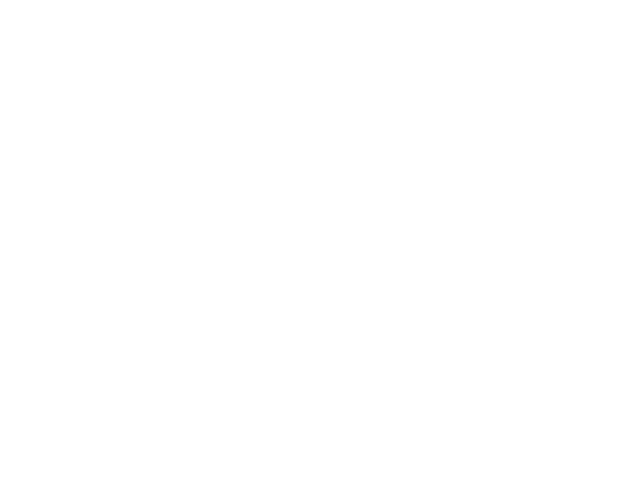

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


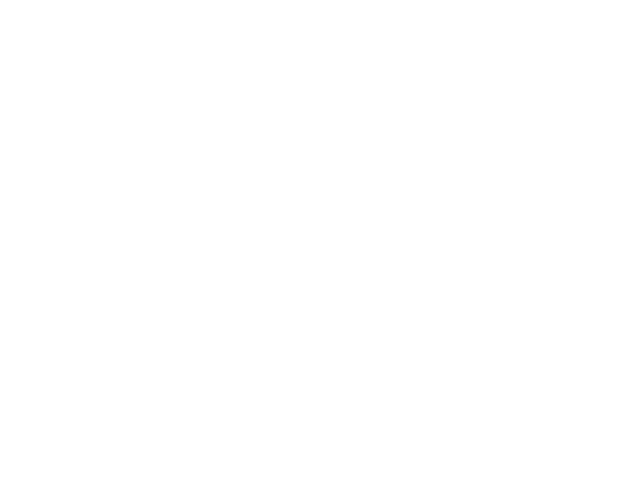

Button(description='Save Figure', style=ButtonStyle())

In [9]:
ax = scalar_plot(data['sim_time'][exp_idx], data['tank_state'][exp_idx], prefix="tank_state")
#ax.plot(data['sim_time'][exp_idx], data['power_from_error'][exp_idx], label="power_from_error")
#ax.plot(data['sim_time'][exp_idx], data['power_from_interaction'][exp_idx], label="power_from_interaction")
ax.axhline(y=2, ls="--")
ax.set_title("Energy tank")
ax.legend()

matrix_plot(data['sim_time'][exp_idx], data['power_channels'][exp_idx], prefix="power_channels")

### Torque measurements

<IPython.core.display.Javascript object>


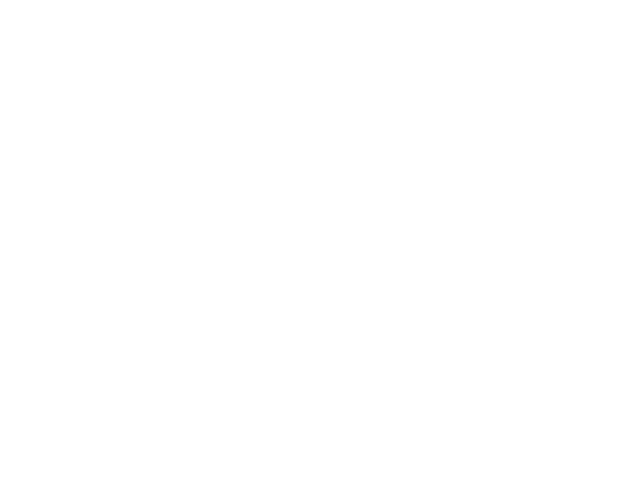

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


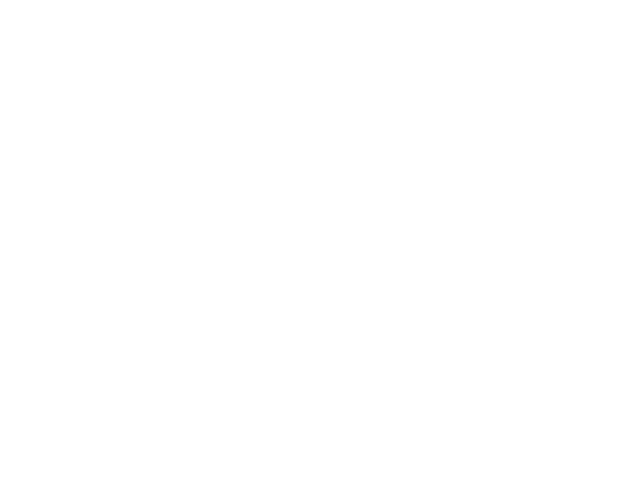

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


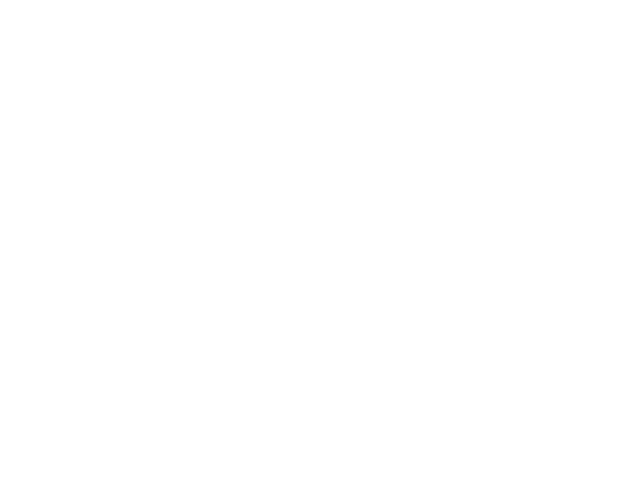

In [10]:
ax2 = matrix_plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx], prefix="external_torque")
ax2.set_title("External measured torque")
ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

ax = matrix_plot(data['sim_time'][exp_idx], data['ground_truth_external_torque'][exp_idx], 
                  prefix="gt_external_torque")
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

# Compare estimated against ground truth
uidx = 6
_, ax3 = plt.subplots()
ax3.plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx][:, uidx], label=f"est_{uidx}")
ax3.plot(data['sim_time'][exp_idx], data['ground_truth_external_torque'][exp_idx][:, uidx], '--', 
         label=f"gt_{uidx}")
ax3.legend()

### Stage cost

<IPython.core.display.Javascript object>


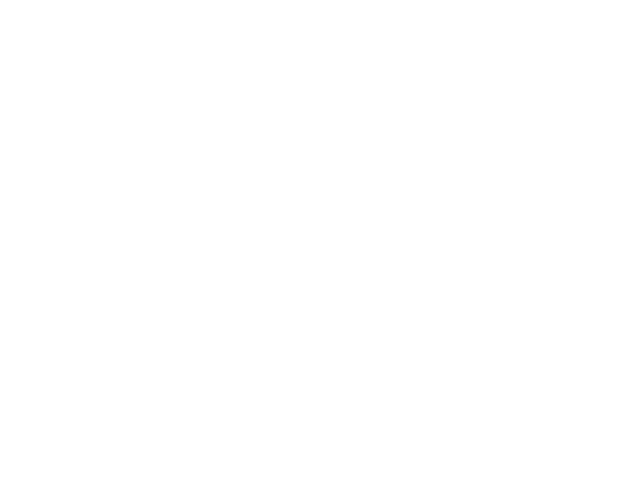

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'stage_cost')

In [11]:
ax = scalar_plot(data['sim_time'][exp_idx], data['stage_cost'][exp_idx], prefix="stage_cost")
ax.set_title("stage_cost")

### Min cost

<IPython.core.display.Javascript object>


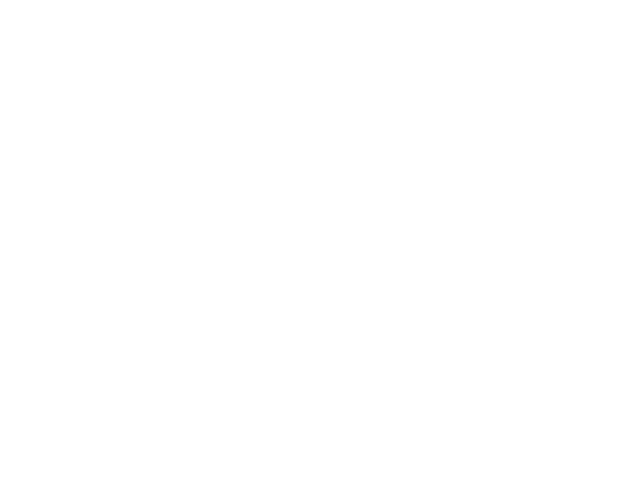

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Minimum rollout cost')

In [12]:
ax = scalar_plot(data['sim_time'][exp_idx], data['min_cost'][exp_idx], prefix="min_cost")
ax.set_title("Minimum rollout cost")

### Position desired

<IPython.core.display.Javascript object>


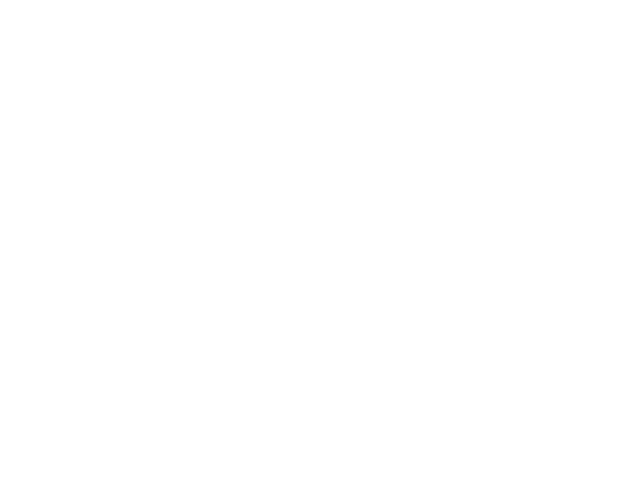

Button(description='Save Figure', style=ButtonStyle())

In [13]:
ax = matrix_plot(data['sim_time'][exp_idx], data['position_desired'][exp_idx], prefix="des")
ax = matrix_plot(data['sim_time'][exp_idx], data['position_measured'][exp_idx], prefix="meas", 
                 linestyle="--", axis=ax)

### Velocity measured

<IPython.core.display.Javascript object>


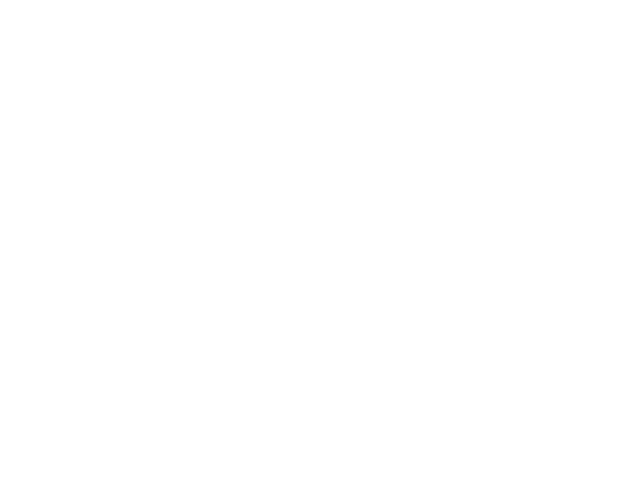

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Velocity measured')

In [14]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx], prefix="velocity_measured")
ax.set_title("Velocity measured")

### Velocity filtered

<IPython.core.display.Javascript object>


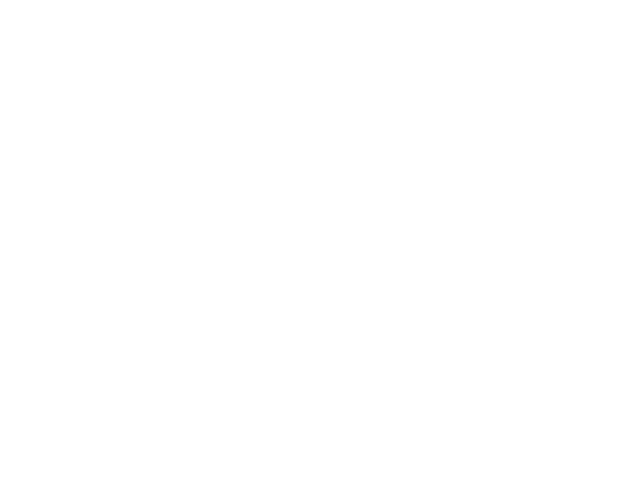

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


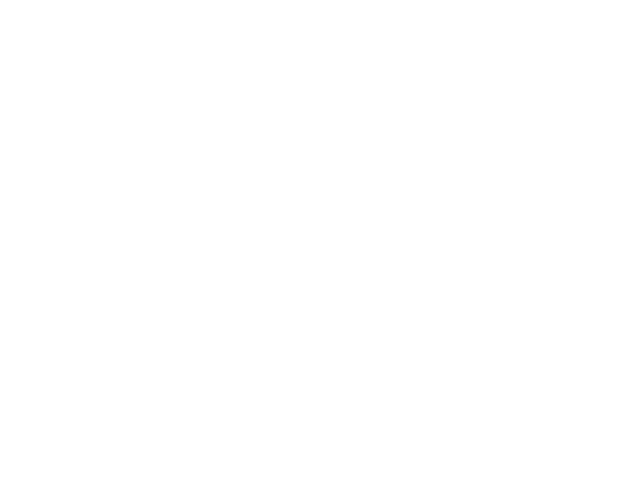

In [15]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx], prefix="velocity_filtered")
ax.set_title("Velocity filtered")

# Compare filtered agains measured
uidx = 0
fig2, ax2 = plt.subplots()
ax2.plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx][:, uidx], label=f"measured_{uidx}")
ax2.plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx][:, uidx], '--', label=f"filtered_{uidx}")
ax2.legend()


### Velocity command

In [16]:
# ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_command'][exp_idx], prefix="velocity_command")
# ax.set_title("Velocity command")

### Torque command

In [17]:
# ax = matrix_plot(data['sim_time'][exp_idx], data['torque_command'][exp_idx], prefix="torque_command")
# ax.set_title("Torque command")

### Joint limits violation

In [18]:
# ax = matrix_plot(data['sim_time'][exp_idx], data['joint_limits_violation'][exp_idx], 
#                  prefix="joint_limits_violation")
# ax.set_title("Joint limits violation")

### Cartesian limits violation

In [19]:
# ax = matrix_plot(data['sim_time'][exp_idx], data['cartesian_limits_violation'][exp_idx], 
#             prefix="cartesian_limits_violation")
# ax.set_title("Cartesian limits violation")

## Constraints analysis
### Joint limits
We compute the cumulative violation summed over all joints

<IPython.core.display.Javascript object>


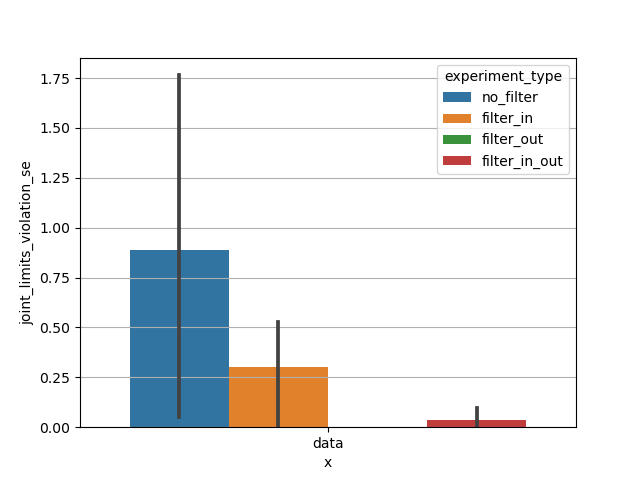

In [29]:
order = ["no_filter", "filter_in", "filter_out", "filter_in_out"]
%matplotlib notebook
ax = sns.barplot(x="x", y="joint_limits_violation_se", hue="experiment_type", hue_order=order, data=data)
plt.show()

### Cartesian limits
We compute the cumulative squared violation of cartesian limits (self collision)

<IPython.core.display.Javascript object>


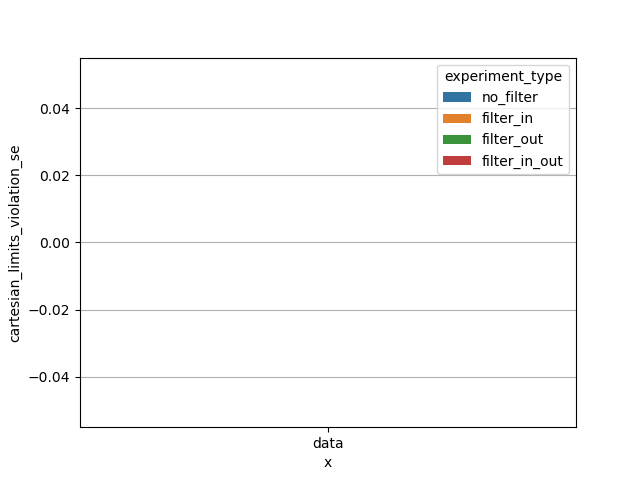

In [30]:
%matplotlib notebook
ax = sns.barplot(x="x", y="cartesian_limits_violation_se", hue="experiment_type", hue_order=order, data=data)   
plt.show()

### Average wrench
We analyse the effect of the energy tank indirectly thorugh a minimized applied wrench

<IPython.core.display.Javascript object>


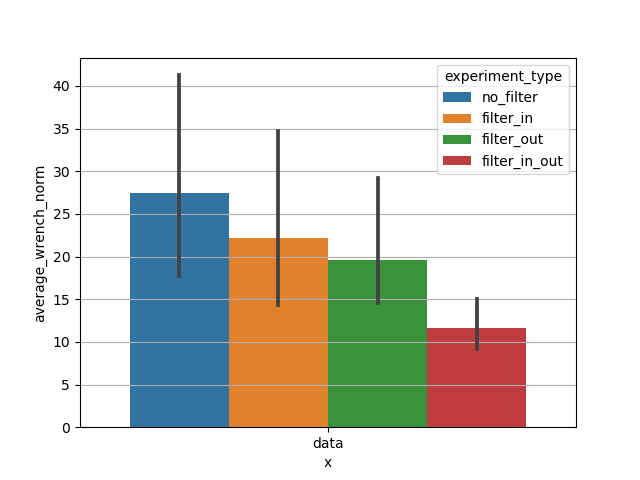

In [31]:
%matplotlib notebook    
sns.barplot(x="x", y="average_wrench_norm", hue="experiment_type", hue_order=order,  data=data)

In [23]:
# cumulate all the values for filter/no_filter experiments
# data_filter = [[], []]
# data_no_filter = [[], []]
# for i, has_filter in enumerate(data['safety_filter']):
#     jlv = data['joint_limits_violation_se'][i]
#     clv = data['cartesian_limits_violation_se'][i]
#     if has_filter:
#         data_filter[0].append(jlv)
#         data_filter[1].append(clv)
#     else:
#         data_no_filter[0].append(jlv)
#         data_no_filter[1].append(clv)

# ax = bar_plot(limits_index, 
#               comparison_labels, 
#               data_no_filter, data_filter)
# ax.set_title("Cumulative violation")

# # cumulate all the values for filter/no_filter experiments
# data_wrench_filter = [[]]
# data_wrench_no_filter = [[]]
# for i, has_filter in enumerate(data['safety_filter']):
#     awn = data['average_wrench_norm'][i]
#     if has_filter:
#         data_wrench_filter[0].append(awn)
#     else:
#         data_wrench_no_filter[0].append(awn)

# ax = bar_plot(["average wrench"], 
#               comparison_labels, 
#               data_wrench_no_filter, data_wrench_filter)
# ax.set_title("Average external wrench")